#### Plotting the variables as in Figure 7 of Giorgetta, 2018

In [ ]:
import numpy as np
import xarray as xr
import psyplot.project as psy
import matplotlib.pyplot as plt
import subprocess
import time
import pandas as pd
import os

In [1]:
-0.000115723

31.64179104477612

In [6]:
# Relevant paths
amip_r2b4 = '/home/b/b309170/bd1179_work/icon-ml_models/icon-a-ml/experiments/ag_atm_amip_r2b4_cfm'
amip_r2b5 = '/home/b/b309170/bd1179_work/icon-ml_models/icon-a-ml/experiments/ag_atm_amip_r2b5'
amip_r2b5_entrmid_crt = '/home/b/b309170/bd1179_work/icon-ml_models/icon-a-ml/experiments/ag_atm_amip_r2b5_entrmid_crt'
amip_r2b5_cvtfall_red = '/home/b/b309170/bd1179_work/icon-ml_models/icon-a-ml/experiments/ag_atm_amip_r2b5_cvtfall_red'

amip_r2b5_cvtfall_entrmid_crt = '/home/b/b309170/bd1179_work/icon-ml_models/icon-a-ml/experiments/ag_atm_amip_r2b5_cvtfall_entrmid_crt'
amip_r2b5_cvtfall_entrmid_crt_05 = '/home/b/b309170/bd1179_work/icon-ml_models/icon-a-ml/experiments/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05'

In [9]:
def fldmean_dataset(dataset, exp_path, var):
    '''
        dataset: xarray dataset
        var: Variable to compute the mean for

        MEAN: cdo fldmean of that dataset
    '''
    tempfile = '/scratch/b/b309170/temp/file_%d.nc'%int(str(time.time()).split('.')[-1])
    tempfile_mean = '/scratch/b/b309170/temp/file_mean_%d.nc'%int(str(time.time()).split('.')[-1])
    dataset.to_netcdf(tempfile)

    if exp_path != None:
        # Extract grid to use setgrid for more precise calculation of the fldmean
        exp_files = os.listdir(exp_path)
        grid_ind = np.argmax(['_grid_' in exp_files[i] for i in range(len(exp_files))])
        grid_path = os.path.join(exp_path, exp_files[grid_ind])

        # Execute bash command within python
        subprocess.run(['cdo', 'timmean', '-fldmean', '-setgrid,%s'%grid_path, '-selname,%s'%var, tempfile, tempfile_mean])
    else:
        # Execute bash command within python
        subprocess.run(['cdo', 'timmean', '-fldmean', '-selname,%s'%var, tempfile, tempfile_mean])                                                                          

    ds_mean = xr.open_dataset(tempfile_mean)
    # MEAN = ds_mean.to_array().values.item()
    var = list(xr.open_dataset(tempfile_mean).variables)[-1] # Sometimes the name of the variable is lost
    MEAN = getattr(ds_mean, var).values.item()

    subprocess.run(['rm', tempfile])
    subprocess.run(['rm', tempfile_mean])

    return MEAN

In [4]:
def print_averages(exp_path):

    # Variables: (a) rsdt - rsut, rlut, (b) prw, (c) rsdt - rsut - rlut, (d) cllvi, clivi, (e) clt, (f) pr

    DS_2d_exp = xr.open_mfdataset(exp_path + '/*atm_2d*.nc', combine='by_coords')

    # Convert time dimension to proper datetime object
    pd_time = pd.to_datetime(pd.Series(DS_2d_exp['time']).astype(str), format='%Y%m%d.0')
    # Update the coordinate 'time' and attach to the existing dimension 'time'
    DS_2d_exp = DS_2d_exp.assign_coords(time=('time', pd_time))

    years = np.arange(1980, 1989)
    # years = np.arange(1980, 1982) #!

    # 8 metrics
    avrgs_exp = 1000*np.ones((8, len(years)))

    # Discard the first year
    year_count = 0
    for year in years:
        DS_2d_exp_1year = DS_2d_exp.sel(time='%d'%year)
        avrgs_exp[0, year_count] = fldmean_dataset(DS_2d_exp_1year, exp_path, "rsdt") - fldmean_dataset(DS_2d_exp_1year, exp_path, "rsut")
        avrgs_exp[1, year_count] = fldmean_dataset(DS_2d_exp_1year, exp_path, "rlut")
        avrgs_exp[2, year_count] = fldmean_dataset(DS_2d_exp_1year, exp_path, "prw")
        avrgs_exp[3, year_count] = fldmean_dataset(DS_2d_exp_1year, exp_path, "rsdt") - fldmean_dataset(DS_2d_exp_1year, exp_path, "rsut") - fldmean_dataset(DS_2d_exp_1year, exp_path, "rlut")
        avrgs_exp[4, year_count] = fldmean_dataset(DS_2d_exp_1year, exp_path, "cllvi")
        avrgs_exp[5, year_count] = fldmean_dataset(DS_2d_exp_1year, exp_path, "clivi")
        avrgs_exp[6, year_count] = fldmean_dataset(DS_2d_exp_1year, exp_path, "clt")
        avrgs_exp[7, year_count] = fldmean_dataset(DS_2d_exp_1year, exp_path, "pr")
        year_count += 1

    avrgs_exp_years = np.mean(avrgs_exp, axis=1)

    # Define table headers
    variables = ['net SW (in-out)', 'rlut', 'prw', 'net SW-rlut', 'cllvi', 'clivi', 'clt', 'pr']
    references = [241.1, 240.2, 24.42, 0.8, 0.052, 0.026, 0.674, 2.92] 

    count = 0
    for var in variables:
        print('%s: %g [ref: %g]'%(var, avrgs_exp_years[count], references[count]))
        count += 1

    print('Done. 24/03/18.')

In [30]:
print_averages(amip_r2b4)

cdi  warning (cdf_set_var): Inconsistent variable definition for clon_bnds!
cdi  warning (cdf_set_var): Inconsistent variable definition for clat_bnds!
cdi  warning (cdf_read_coordinates): Time varying grid x-bounds unsupported, skipped!
cdi  warning (cdf_read_coordinates): Time varying grid y-bounds unsupported, skipped!
cdi  warning (cdf_set_var): Inconsistent variable definition for clon_bnds!
cdi  warning (cdf_set_var): Inconsistent variable definition for clat_bnds!
cdi  warning (cdf_read_coordinates): Time varying grid x-bounds unsupported, skipped!
cdi  warning (cdf_read_coordinates): Time varying grid y-bounds unsupported, skipped!
cdi  warning (cdf_set_var): Inconsistent variable definition for clon_bnds!
cdi  warning (cdf_set_var): Inconsistent variable definition for clat_bnds!
cdi  warning (cdf_read_coordinates): Time varying grid x-bounds unsupported, skipped!
cdi  warning (cdf_read_coordinates): Time varying grid y-bounds unsupported, skipped!
cdi  warning (cdf_set_var): 

net SW (in-out): 237.579 [ref: 241.1]
rlut: 239.089 [ref: 240.2]
prw: 24.3403 [ref: 24.42]
net SW-rlut: -1.50968 [ref: 0.8]
cllvi: 0.0820039 [ref: 0.052]
clivi: 0.0463642 [ref: 0.026]
clt: 0.610894 [ref: 0.674]
pr: 3.19201e-05 [ref: 2.92]
Done. 24/03/18.


In [31]:
print_averages(amip_r2b5)

cdi  warning (cdf_set_var): Inconsistent variable definition for clon_bnds!
cdi  warning (cdf_set_var): Inconsistent variable definition for clat_bnds!
cdi  warning (cdf_read_coordinates): Time varying grid x-bounds unsupported, skipped!
cdi  warning (cdf_read_coordinates): Time varying grid y-bounds unsupported, skipped!
cdi  warning (cdf_set_var): Inconsistent variable definition for clon_bnds!
cdi  warning (cdf_set_var): Inconsistent variable definition for clat_bnds!
cdi  warning (cdf_read_coordinates): Time varying grid x-bounds unsupported, skipped!
cdi  warning (cdf_read_coordinates): Time varying grid y-bounds unsupported, skipped!
cdi  warning (cdf_set_var): Inconsistent variable definition for clon_bnds!
cdi  warning (cdf_set_var): Inconsistent variable definition for clat_bnds!
cdi  warning (cdf_read_coordinates): Time varying grid x-bounds unsupported, skipped!
cdi  warning (cdf_read_coordinates): Time varying grid y-bounds unsupported, skipped!
cdi  warning (cdf_set_var): 

In [29]:
print_averages(amip_r2b5_entrmid_crt)

cdi  warning (cdf_set_var): Inconsistent variable definition for clon_bnds!
cdi  warning (cdf_set_var): Inconsistent variable definition for clat_bnds!
cdi  warning (cdf_read_coordinates): Time varying grid x-bounds unsupported, skipped!
cdi  warning (cdf_read_coordinates): Time varying grid y-bounds unsupported, skipped!
cdi  warning (cdf_set_var): Inconsistent variable definition for clon_bnds!
cdi  warning (cdf_set_var): Inconsistent variable definition for clat_bnds!
cdi  warning (cdf_read_coordinates): Time varying grid x-bounds unsupported, skipped!
cdi  warning (cdf_read_coordinates): Time varying grid y-bounds unsupported, skipped!
cdi  warning (cdf_set_var): Inconsistent variable definition for clon_bnds!
cdi  warning (cdf_set_var): Inconsistent variable definition for clat_bnds!
cdi  warning (cdf_read_coordinates): Time varying grid x-bounds unsupported, skipped!
cdi  warning (cdf_read_coordinates): Time varying grid y-bounds unsupported, skipped!
cdi  warning (cdf_set_var): 

net SW (in-out): 236.856 [ref: 241.1]
rlut: 240.387 [ref: 240.2]
prw: 24.3386 [ref: 24.42]
net SW-rlut: -3.53073 [ref: 0.8]
cllvi: 0.0894529 [ref: 0.052]
clivi: 0.0479707 [ref: 0.026]
clt: 0.617101 [ref: 0.674]
pr: 3.22066e-05 [ref: 2.92]
Done. 24/03/18.


In [28]:
print_averages(amip_r2b5_cvtfall_red)

cdi  warning (cdf_set_var): Inconsistent variable definition for clon_bnds!
cdi  warning (cdf_set_var): Inconsistent variable definition for clat_bnds!
cdi  warning (cdf_read_coordinates): Time varying grid x-bounds unsupported, skipped!
cdi  warning (cdf_read_coordinates): Time varying grid y-bounds unsupported, skipped!
cdi  warning (cdf_set_var): Inconsistent variable definition for clon_bnds!
cdi  warning (cdf_set_var): Inconsistent variable definition for clat_bnds!
cdi  warning (cdf_read_coordinates): Time varying grid x-bounds unsupported, skipped!
cdi  warning (cdf_read_coordinates): Time varying grid y-bounds unsupported, skipped!
cdi  warning (cdf_set_var): Inconsistent variable definition for clon_bnds!
cdi  warning (cdf_set_var): Inconsistent variable definition for clat_bnds!
cdi  warning (cdf_read_coordinates): Time varying grid x-bounds unsupported, skipped!
cdi  warning (cdf_read_coordinates): Time varying grid y-bounds unsupported, skipped!
cdi  warning (cdf_set_var): 

net SW (in-out): 240.758 [ref: 241.1]
rlut: 239.136 [ref: 240.2]
prw: 24.9817 [ref: 24.42]
net SW-rlut: 1.62179 [ref: 0.8]
cllvi: 0.0720748 [ref: 0.052]
clivi: 0.0483105 [ref: 0.026]
clt: 0.61118 [ref: 0.674]
pr: 3.16307e-05 [ref: 2.92]
Done. 24/03/18.


In [7]:
print_averages(amip_r2b5_cvtfall_entrmid_crt)

INFO:numexpr.utils:Note: detected 256 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 256 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
cdi  warning (cdf_set_var): Inconsistent variable definition for clon_bnds!
cdi  warning (cdf_set_var): Inconsistent variable definition for clat_bnds!
cdi  warning (cdf_read_coordinates): Time varying grid x-bounds unsupported, skipped!
cdi  warning (cdf_read_coordinates): Time varying grid y-bounds unsupported, skipped!
cdi  warning (cdf_set_var): Inconsistent variable definition for clon_bnds!
cdi  warning (cdf_set_var): Inconsistent variable definition for clat_bnds!
cdi  warning (cdf_read_coordinates): Time varying grid x-bounds unsupported, skipped!
cdi  warning (cdf_read_coordinates): Time varying grid y-bounds unsupported, skipped!
cdi  warning (cdf_set_var): Inconsistent variab

net SW (in-out): 239.769 [ref: 241.1]
rlut: 239.03 [ref: 240.2]
prw: 24.9082 [ref: 24.42]
net SW-rlut: 0.739029 [ref: 0.8]
cllvi: 0.0745178 [ref: 0.052]
clivi: 0.048718 [ref: 0.026]
clt: 0.61361 [ref: 0.674]
pr: 3.15966e-05 [ref: 2.92]
Done. 24/03/18.


In [8]:
print_averages(amip_r2b5_cvtfall_entrmid_crt_05)

cdi  warning (cdf_set_var): Inconsistent variable definition for clon_bnds!
cdi  warning (cdf_set_var): Inconsistent variable definition for clat_bnds!
cdi  warning (cdf_read_coordinates): Time varying grid x-bounds unsupported, skipped!
cdi  warning (cdf_read_coordinates): Time varying grid y-bounds unsupported, skipped!
cdi  warning (cdf_set_var): Inconsistent variable definition for clon_bnds!
cdi  warning (cdf_set_var): Inconsistent variable definition for clat_bnds!
cdi  warning (cdf_read_coordinates): Time varying grid x-bounds unsupported, skipped!
cdi  warning (cdf_read_coordinates): Time varying grid y-bounds unsupported, skipped!
cdi  warning (cdf_set_var): Inconsistent variable definition for clon_bnds!
cdi  warning (cdf_set_var): Inconsistent variable definition for clat_bnds!
cdi  warning (cdf_read_coordinates): Time varying grid x-bounds unsupported, skipped!
cdi  warning (cdf_read_coordinates): Time varying grid y-bounds unsupported, skipped!
cdi  warning (cdf_set_var): 

net SW (in-out): 241.108 [ref: 241.1]
rlut: 240.434 [ref: 240.2]
prw: 24.7184 [ref: 24.42]
net SW-rlut: 0.673342 [ref: 0.8]
cllvi: 0.0739562 [ref: 0.052]
clivi: 0.047322 [ref: 0.026]
clt: 0.605299 [ref: 0.674]
pr: 3.19465e-05 [ref: 2.92]
Done. 24/03/18.


In [5]:
avrgs_r2b4_years = np.mean(avrgs_r2b4, axis=1)

# Define table headers
variables = ['net SW (in-out)', 'rlut', 'prw', 'net SW-rlut', 'cllvi', 'clivi', 'clt', 'pr']
references = [241.1, 240.2, 24.42, 0.8, 0.052, 0.026, 0.674, 2.92] 

count = 0
for var in variables:
    print('%s: %g [ref: %g]'%(var, avrgs_r2b4_years[count], references[count]))
    count += 1

print('Done. 23/12/22.')

net SW (in-out): 237.696 [ref: 241.1]
rlut: 239.25 [ref: 240.2]
prw: 24.3067 [ref: 24.42]
net SW-rlut: -1.55357 [ref: 0.8]
cllvi: 0.0815081 [ref: 0.052]
clivi: 0.0460214 [ref: 0.026]
clt: 0.608245 [ref: 0.674]
pr: 3.17419e-05 [ref: 2.92]
Done. 23/12/22.


In [10]:
# ERA5 clt, pr
DS_clt_era5 = xr.open_dataset('/home/b/b309170/bd1179_work/ERA5/orig_files/Tier3/ERA5/v1/stats/era5_averages_1979-1989_clt.nc')
DS_pr_era5 = xr.open_dataset('/home/b/b309170/bd1179_work/ERA5/orig_files/Tier3/ERA5/v1/stats/era5_averages_1979-1989_pr.nc')

era5_clt = fldmean_dataset(DS_clt_era5, exp_path=None, var='tcc')
era5_pr = fldmean_dataset(DS_pr_era5, exp_path=None, var='tp')

# Convert pr from m/month to mm/day
era5_pr_mmday = 1000*era5_pr

Barplots

In [36]:
variables = ['net shortwave (in-out) [W/m2]', 'net longwave (out-in) [W/m2]', 'prw [kg/m2]', 'TOA balance [W/m2]', 'cllvi [kg/m2]', 'clivi [kg/m2]', 
             'total cloud cover', 'pr [mm/day]']

# From Giorgetta, 2018
gio_obs_ref = [241.1, 240.2, 24.42, 0.8, 0, 0, 0.674, 0]
icon_aes_130_gio_ref = [241.1, 240.7, 24.6, 0.4, 0.052, 0.026, 0.637, 2.97]

# The new simulations (convert precip from kg/(m^2 s) to mm/day)
icon_264_r2b4 = [237.579, 239.089, 24.3403, -1.50968, 0.0820039, 0.0463642, 0.610894, 3.19201e-05*60*60*24] # Updated
icon_264_r2b5 = [242.192, 241.541, 24.5707, 0.651568, 0.0739695, 0.0458262, 0.595209, 3.22046e-05*60*60*24] #!
icon_264_entrmid_crt = [236.856, 240.387, 24.3386, -3.53073, 0.0894529, 0.0479707, 0.617101, 3.22066e-05*60*60*24] # Updated
icon_264_cvtfall_red = [240.758, 239.136, 24.9817, 1.62179, 0.0720748, 0.0483105, 0.61118, 3.16307e-05*60*60*24] # Updated
icon_264_cvtfall_entrmid_crt = [239.769, 239.03, 24.9082, 0.739029, 0.0745178, 0.048718, 0.61361, 3.15966e-05*60*60*24] # Updated
icon_264_cvtfall_entrmid_crt_05 = [241.108, 240.434, 24.7184, 0.673342, 0.0739562, 0.047322, 0.605299, 3.19465e-05*60*60*24] # Updated

In [12]:
import matplotlib

# Increase the general font size
matplotlib.rcParams['legend.fontsize'] = 'x-large'
matplotlib.rcParams['axes.labelsize'] = 'x-large' # For an axes xlabel and ylabel
matplotlib.rcParams['axes.titlesize'] = 'x-large'
matplotlib.rcParams['xtick.labelsize'] = 'xx-large'
matplotlib.rcParams['ytick.labelsize'] = 'xx-large'

In [ ]:
# Includes also two ICON-A tuning experiments

plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.4)

labels = ['OBS Gio. 2018\n (usually CERES)', 'ICON 1.3', 'R2B4', 'R2B5', 'ICON R2B5 T1', 'ICON R2B5 T2']
labels_ext = ['OBS Gio. 2018\n (usually CERES)', 'ERA5', 'ICON 1.3', 'ICON R2B4', 'ICON R2B5', 'ICON R2B5 T1', 'ICON R2B5 T2']

axes = (0,1,2,3,4,5,6,7)
for i, par in enumerate(variables):
    # Add new subplot iteratively
    ax = plt.subplot(4, 2, i + 1)

    axis = axes[:i] + axes[(i+1):]
    if par not in ['clt', 'pr [mm/day]']:
        ax.bar(labels, [gio_obs_ref[i], icon_aes_130_gio_ref[i], icon_264_r2b4[i], icon_264_r2b5[i], icon_264_entrmid_crt[i], icon_264_entrmid_crt[i]])
    elif par == 'clt':
        ax.bar(labels_ext, [gio_obs_ref[i], era5_clt, icon_aes_130_gio_ref[i], icon_264_r2b4[i], icon_264_r2b5[i], icon_264_entrmid_crt[i], icon_264_entrmid_crt[i]])
    elif par == 'pr [mm/day]':
        ax.bar(labels_ext, [gio_obs_ref[i], era5_pr_mmday, icon_aes_130_gio_ref[i], icon_264_r2b4[i], icon_264_r2b5[i], icon_264_entrmid_crt[i], icon_264_entrmid_crt[i]])

    if i == 0:
        plt.ylim([235, 245])
    elif i == 1:
        plt.ylim([235, 245])
    elif i == 2:
        plt.ylim([23.8, 25.8])
    elif i == 3:
        plt.ylim([-2, 1])
    elif i == 6:
        plt.ylim([0.58, 0.68])
    elif i == 7:
        plt.ylim([2, 3.2])

    plt.legend([])
    plt.xlabel(par)
    plt.savefig('pdfs/gio_fig7_ext.pdf')

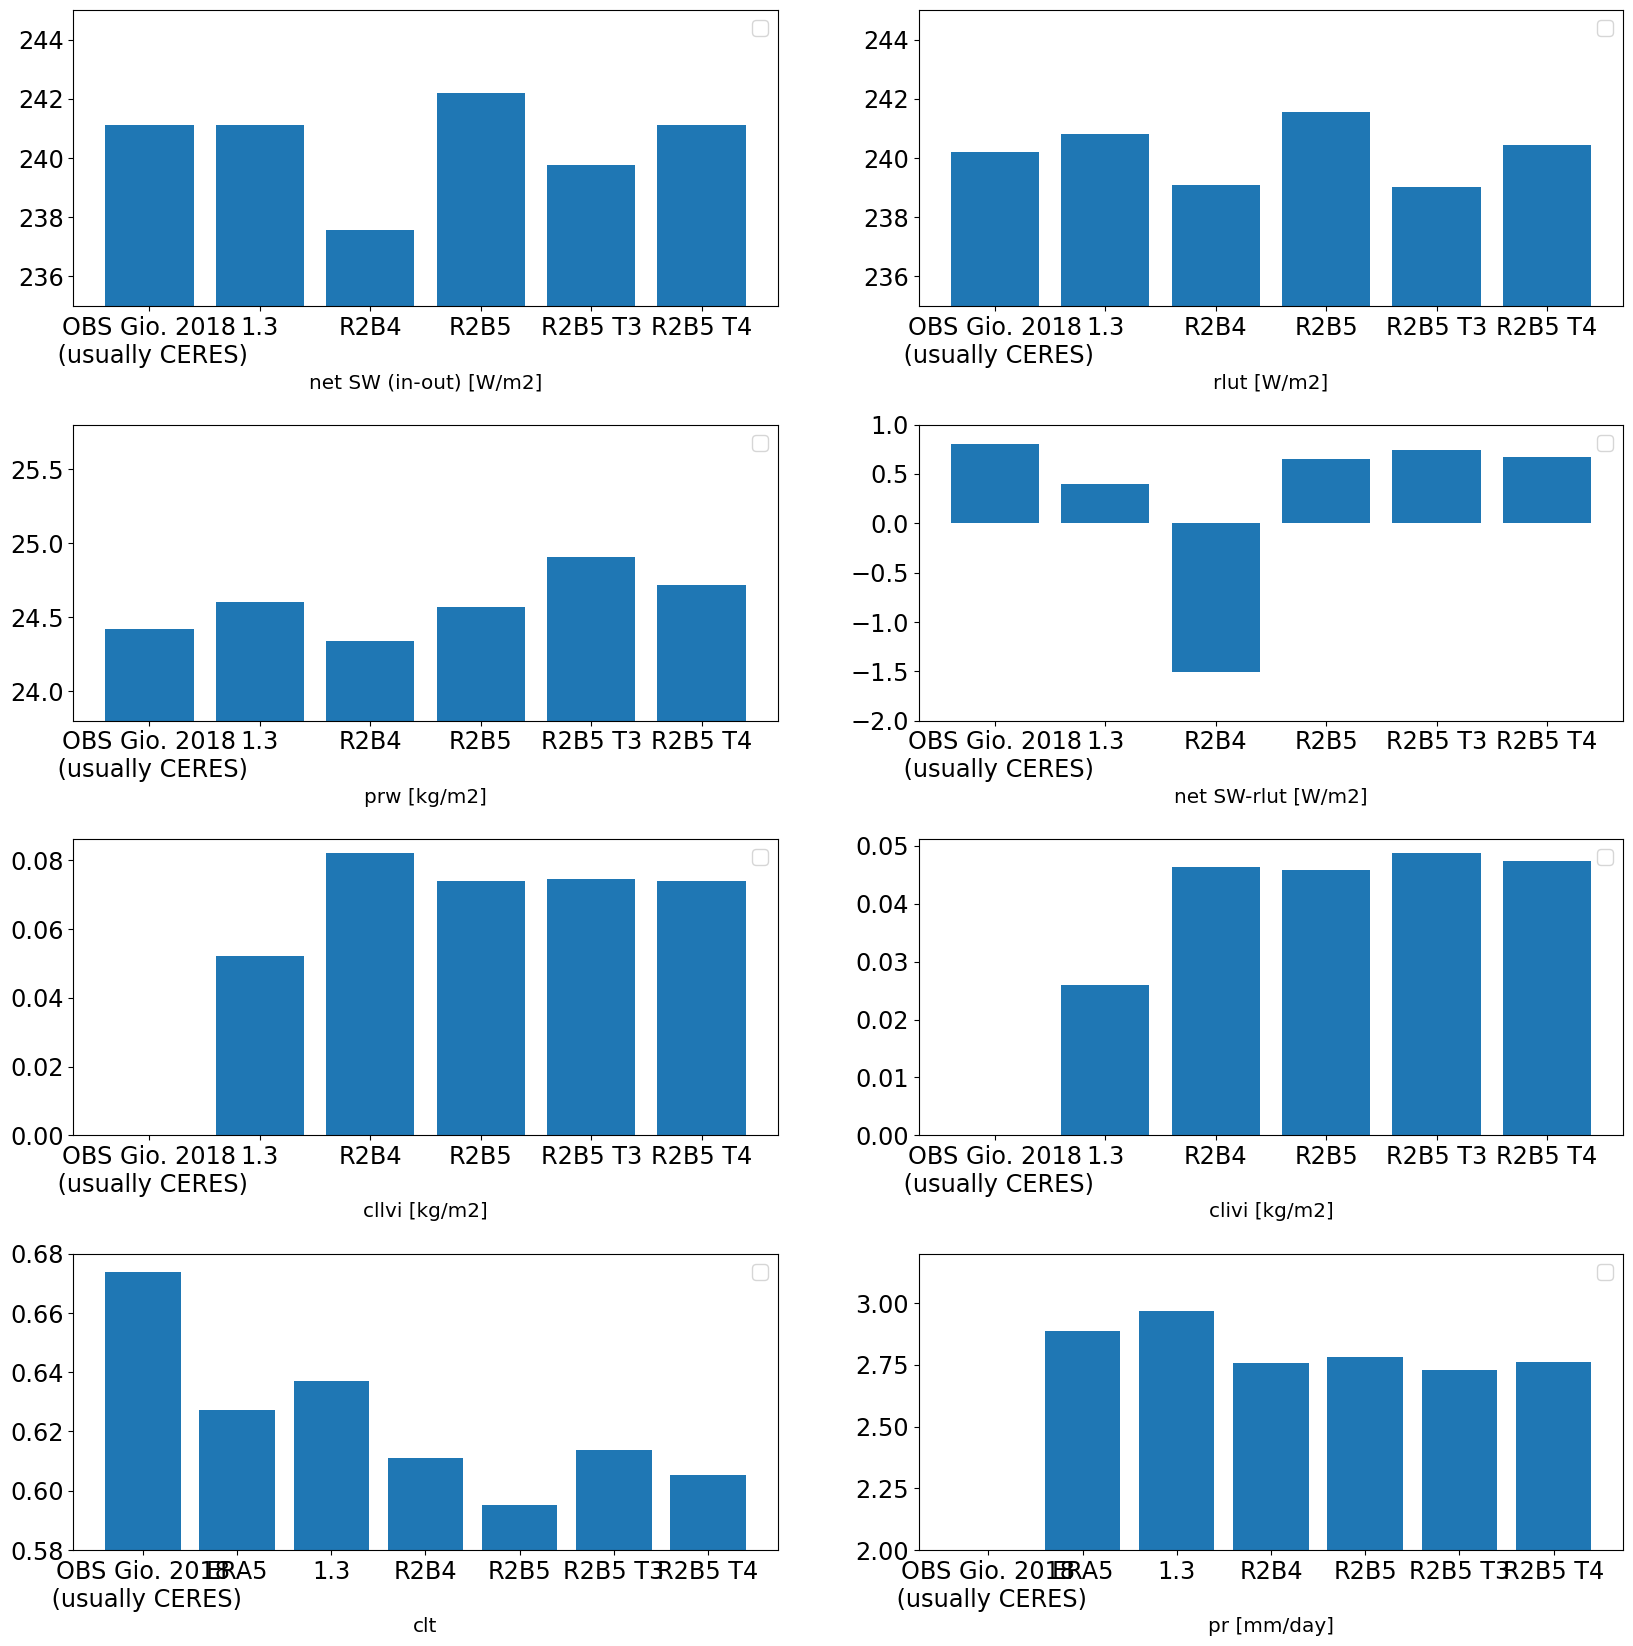

In [16]:
# Includes the third and forth ICON-A tuning experiments

plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.4)

labels = ['OBS Gio. 2018\n (usually CERES)', '1.3', 'R2B4', 'R2B5', 'R2B5 T3', 'R2B5 T4']
labels_ext = ['OBS Gio. 2018\n (usually CERES)', 'ERA5', '1.3', 'R2B4', 'R2B5', 'R2B5 T3', 'R2B5 T4']

axes = (0,1,2,3,4,5,6,7)
for i, par in enumerate(variables):
    # Add new subplot iteratively
    ax = plt.subplot(4, 2, i + 1)

    axis = axes[:i] + axes[(i+1):]
    if par not in ['clt', 'pr [mm/day]']:
        ax.bar(labels, [gio_obs_ref[i], icon_aes_130_gio_ref[i], icon_264_r2b4[i], icon_264_r2b5[i], icon_264_cvtfall_entrmid_crt[i], icon_264_cvtfall_entrmid_crt_05[i]])
    elif par == 'clt':
        ax.bar(labels_ext, [gio_obs_ref[i], era5_clt, icon_aes_130_gio_ref[i], icon_264_r2b4[i], icon_264_r2b5[i], icon_264_cvtfall_entrmid_crt[i], icon_264_cvtfall_entrmid_crt_05[i]])
    elif par == 'pr [mm/day]':
        ax.bar(labels_ext, [gio_obs_ref[i], era5_pr_mmday, icon_aes_130_gio_ref[i], icon_264_r2b4[i], icon_264_r2b5[i], icon_264_cvtfall_entrmid_crt[i], icon_264_cvtfall_entrmid_crt_05[i]])

    if i == 0:
        plt.ylim([235, 245])
    elif i == 1:
        plt.ylim([235, 245])
    elif i == 2:
        plt.ylim([23.8, 25.8])
    elif i == 3:
        plt.ylim([-2, 1])
    elif i == 6:
        plt.ylim([0.58, 0.68])
    elif i == 7:
        plt.ylim([2, 3.2])

    plt.legend([])
    plt.xlabel(par)
    plt.savefig('pdfs/gio_fig7_ext_2.pdf')

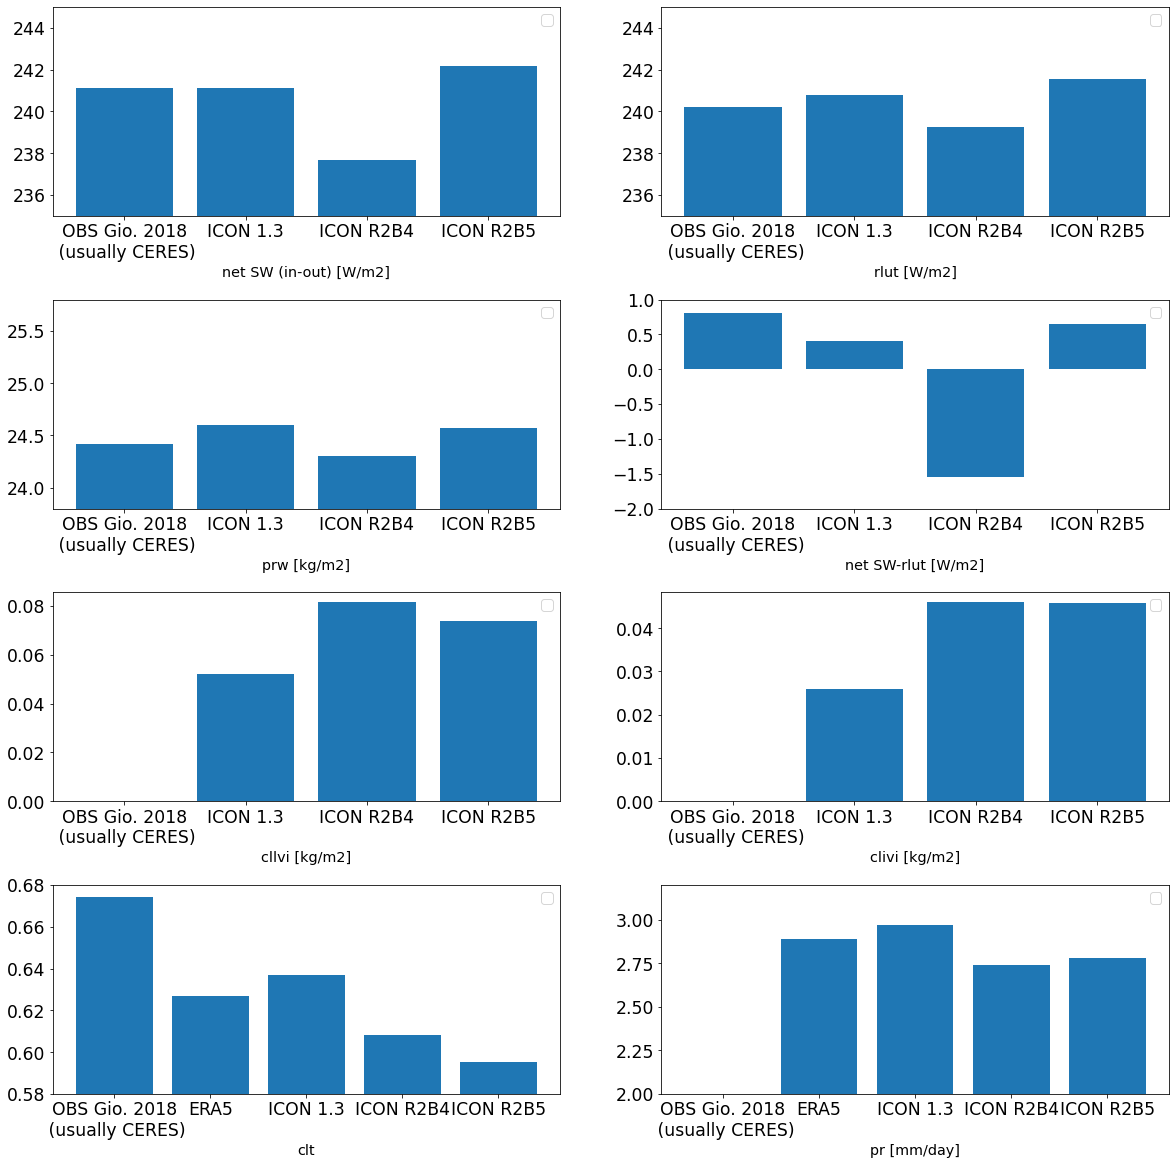

In [42]:
# Comparison of default ICON-A 2.6.4. simulations

plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.4)

labels = ['OBS Gio. 2018\n (usually CERES)', 'ICON 1.3', 'ICON R2B4', 'ICON R2B5']
labels_ext = ['OBS Gio. 2018\n (usually CERES)', 'ERA5', 'ICON 1.3', 'ICON R2B4', 'ICON R2B5']

axes = (0,1,2,3,4,5,6,7)
for i, par in enumerate(variables):
    # Add new subplot iteratively
    ax = plt.subplot(4, 2, i + 1)

    axis = axes[:i] + axes[(i+1):]
    if par not in ['clt', 'pr [mm/day]']:
        ax.bar(labels, [gio_obs_ref[i], icon_aes_130_gio_ref[i], icon_264_r2b4[i], icon_264_r2b5[i]])
    elif par == 'clt':
        ax.bar(labels_ext, [gio_obs_ref[i], era5_clt, icon_aes_130_gio_ref[i], icon_264_r2b4[i], icon_264_r2b5[i]])
    elif par == 'pr [mm/day]':
        ax.bar(labels_ext, [gio_obs_ref[i], era5_pr_mmday, icon_aes_130_gio_ref[i], icon_264_r2b4[i], icon_264_r2b5[i]])

    if i == 0:
        plt.ylim([235, 245])
    elif i == 1:
        plt.ylim([235, 245])
    elif i == 2:
        plt.ylim([23.8, 25.8])
    elif i == 3:
        plt.ylim([-2, 1])
    elif i == 6:
        plt.ylim([0.58, 0.68])
    elif i == 7:
        plt.ylim([2, 3.2])

    plt.legend([])
    plt.xlabel(par)
    plt.savefig('pdfs/gio_fig7.pdf')

In [29]:
import matplotlib

# Increase the general font size
matplotlib.rcParams['legend.fontsize'] = 'x-large'
matplotlib.rcParams['axes.labelsize'] = 'xx-large' # For an axes xlabel and ylabel
matplotlib.rcParams['axes.titlesize'] = 'xx-large'
matplotlib.rcParams['xtick.labelsize'] = 'xx-large'
matplotlib.rcParams['ytick.labelsize'] = 'xx-large'

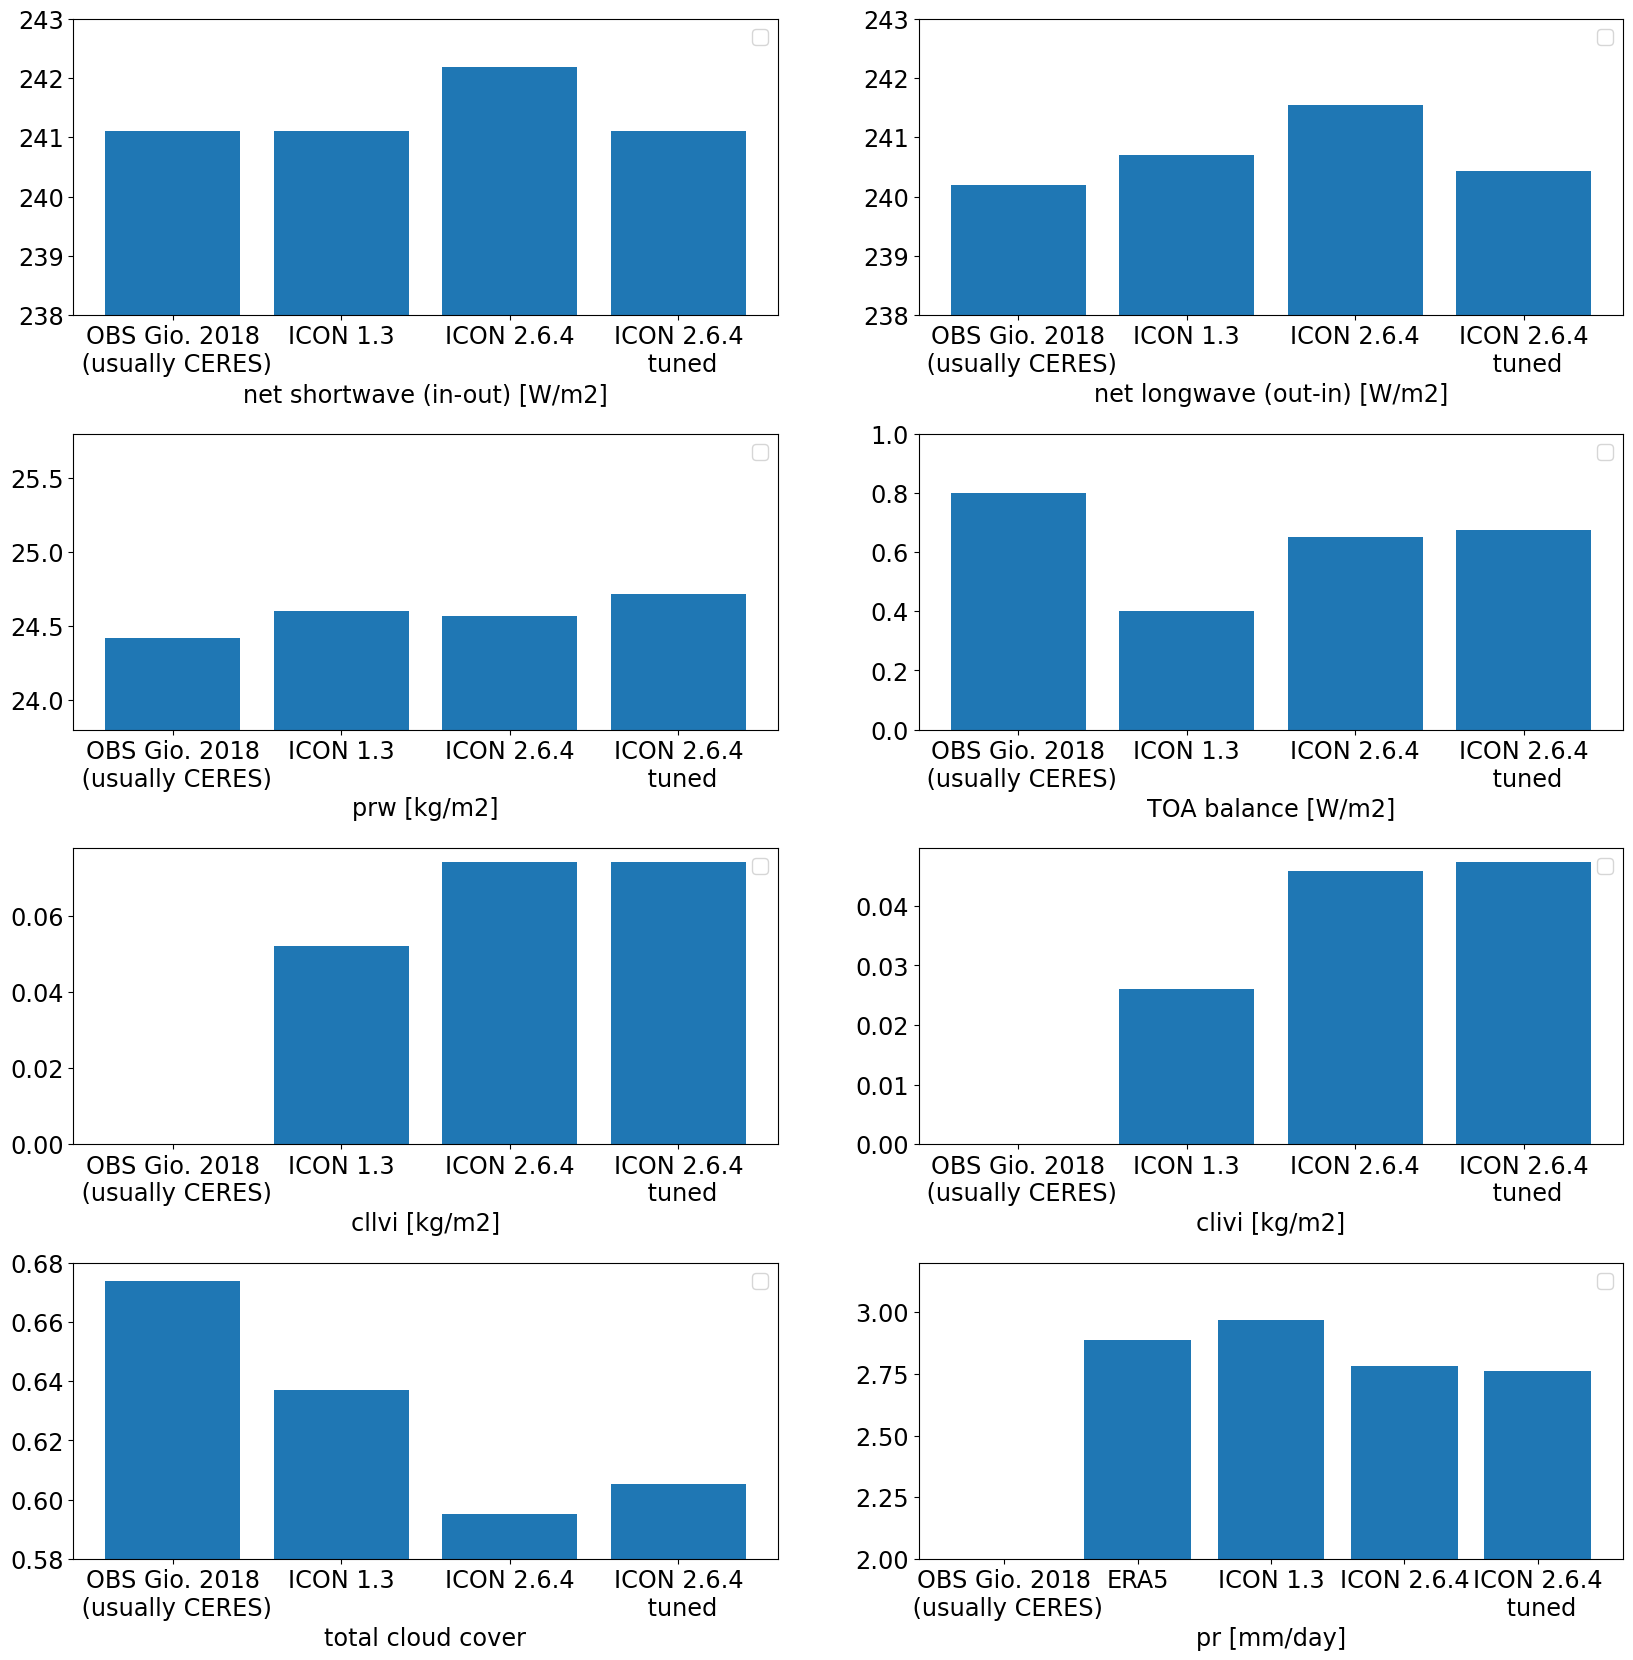

In [38]:
# Comparison of default ICON-A 2.6.4. simulations

plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.4)

labels = ['OBS Gio. 2018\n (usually CERES)', 'ICON 1.3', 'ICON 2.6.4', 'ICON 2.6.4\n tuned']
labels_ext = ['OBS Gio. 2018\n (usually CERES)', 'ERA5', 'ICON 1.3', 'ICON 2.6.4', 'ICON 2.6.4\n tuned']

axes = (0,1,2,3,4,5,6,7)
for i, par in enumerate(variables):
    # Add new subplot iteratively
    ax = plt.subplot(4, 2, i + 1)

    axis = axes[:i] + axes[(i+1):]
    if par not in ['clt', 'pr [mm/day]']:
        ax.bar(labels, [gio_obs_ref[i], icon_aes_130_gio_ref[i], icon_264_r2b5[i], icon_264_cvtfall_entrmid_crt_05[i]])
    elif par == 'clt':
        ax.bar(labels_ext, [gio_obs_ref[i], era5_clt, icon_aes_130_gio_ref[i], icon_264_r2b5[i], icon_264_cvtfall_entrmid_crt_05[i]])
    elif par == 'pr [mm/day]':
        ax.bar(labels_ext, [gio_obs_ref[i], era5_pr_mmday, icon_aes_130_gio_ref[i], icon_264_r2b5[i], icon_264_cvtfall_entrmid_crt_05[i]])

    if i == 0:
        plt.ylim([238, 243])
    elif i == 1:
        plt.ylim([238, 243])
    elif i == 2:
        plt.ylim([23.8, 25.8])
    elif i == 3:
        plt.ylim([0, 1])
    elif i == 6:
        plt.ylim([0.58, 0.68])
    elif i == 7:
        plt.ylim([2, 3.2])

    plt.legend([])
    plt.xlabel(par)
    # plt.savefig('pdfs/gio_fig7.pdf')